<h3>«Модель прогнозирования
стоимости жилья для агентства недвижимости»</h3>

In [ ]:
#импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
import ydata_profiling
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

<h2>Анализ данных</h2>

Заранее проговарим, что в исходном датафрейме данные требуют тщательного анализа и модификации, для точности прогнозирования будущей модели
<br>Какие столбцы мы изначально имеем:<br>
'status' — статус продажи;  
'private pool' и 'PrivatePool' — наличие собственного бассейна;  
'propertyType' — тип объекта недвижимости;  
'street' — адрес объекта;  
'baths' — количество ванных комнат;  
'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);  
'fireplace' — наличие камина;  
'city' — город;  
'schools' — сведения о школах в районе;  
'sqft' — площадь в футах;  
'zipcode' — почтовый индекс;  
'beds' — количество спален;  
'state' — штат;  
'stories' — количество этажей;  
'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);  
'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать)

In [ ]:
#рассмотрим наш датафрейм
df=pd.read_csv('data.csv')
df.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


In [ ]:
df.shape

(377185, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Уже можно сделать вывод что придётся работать с типами данных

In [ ]:
#посмотрим на уровень пропусков в даных
missing_data_in_df=pd.DataFrame({'NaN_Counts': df.isna().sum(), 'NaN_Proportions(%)': (df.isna().sum() / df.shape[0]) * 100}).sort_values(by='NaN_Counts', ascending=False)
missing_data_in_df.head()

,NaN_Counts,NaN_Proportions(%)
private pool,373004,98.891525
mls-id,352243,93.387330
PrivatePool,336874,89.312672
fireplace,274071,72.662221
stories,150716,39.958111


Перед тем, как сразу же удалять данные с большим количеством пропусков, поработаем с каждым признаком отдельно

Обработаем данные через ydata_profiling:

In [ ]:
#profile = ydata_profiling.ProfileReport(df, title="Profiling Report")
#profile.to_notebook_iframe()

In [ ]:
#сохраним полученный отчёт
#profile.to_file("data_report.html")

Из полученных данных, следует подтверждение представления о наличии таких проблем, как: пропуски в данных, большая вариативность переменных типа object, также можно отметить наличие дубликатов

In [ ]:
#Оценим число дубликатов
df.duplicated().sum()

50

In [ ]:
df = df.drop_duplicates(ignore_index=True) #удалим дубликаты

Удалим строки в которых более 7 столбцов содержат пропуски

<h5>Перейдём к работе со столбцами</h5>

<h4>1.Столбцы 'mls-id' и 'MlsId'</h4>

Начнём с простого, уменьшим размерность, очевидно индентификаторы вызывают вопросы о степени влияния на стоимость.

In [ ]:
df['mls-id'].value_counts()

mls-id
No MLS#      3
No           3
1498550      2
39888954     2
608063       2
            ..
1020314      1
A10762436    1
1592770      1
14201834     1
F10202858    1
Name: count, Length: 24907, dtype: int64

In [ ]:
df['MlsId'].value_counts()

MlsId
NO MLS                     24
No MLS #                   16
 A, Houston, TX 77008      13
 12A, Orlando, FL 32833    11
No                          9
                           ..
219080357                   1
PAPH850238                  1
RX-10580440                 1
10515909                    1
10374233                    1
Name: count, Length: 232944, dtype: int64

Большая вариативность переменных, отсутствие преобладающих значений, многие значения не заполнены, логическая связь с таргетом не наблдается, удалим атрибуты

In [ ]:
df.drop(['mls-id','MlsId'],axis=1, inplace=True)

Продолжая уменьшать размерность, обратим внимание на столбцы отвечающие за одну и ту же функцию 'private pool' и 'PrivatePool'.

<h4>2.'private pool' и 'PrivatePool'</h4>

In [ ]:
df['private pool'].value_counts()

private pool
Yes    4181
Name: count, dtype: int64

In [ ]:
df['PrivatePool'].value_counts()

PrivatePool
yes    28792
Yes    11518
Name: count, dtype: int64

Посмотрим на их отношение друг с другом

In [ ]:
df_pool=df[['private pool', 'PrivatePool']]

In [ ]:
# Выведем строки, заполненные в колонке 'private pool' и отсутствующие в колонке 'PrivatePool'
df_pool[df_pool['private pool'].notnull() & df_pool['PrivatePool'].isnull()]

,private pool,PrivatePool
205,Yes,NaN
321,Yes,NaN
355,Yes,NaN
404,Yes,NaN
425,Yes,NaN
...,...,...
376577,Yes,NaN
376636,Yes,NaN
376644,Yes,NaN
376803,Yes,NaN


In [ ]:
df_pool[df['PrivatePool'].notnull() & df_pool['private pool'].isnull()]

,private pool,PrivatePool
2,NaN,yes
12,NaN,yes
19,NaN,yes
43,NaN,yes
60,NaN,Yes
...,...,...
377118,NaN,yes
377120,NaN,Yes
377121,NaN,yes
377124,NaN,yes


Судя по всему значения не пересекаются

In [ ]:
df.drop(['PrivatePool', 'private pool'], axis=1).duplicated().sum()#дублирующие строки без указанных колонок для возможного анализа смысла колонок

91

In [ ]:
df_dup=df[df.drop(['PrivatePool', 'private pool'], axis=1).duplicated()]
df_dup[(df_dup['PrivatePool'].notnull()) | (df_dup['private pool'].notnull())]
#все дубли содержат Nan в требуемых колонках

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target


Оценить на примере одного дома, как изменяется стоимость в зависимости от колонки не получится, тогда просто объеденим значения в колонках

Объеденим значения колонок, заменим на логические выражения true/false

In [ ]:
df['PrivatePool'] = df['private pool'].fillna(df['PrivatePool'])
df['PrivatePool'] = df['PrivatePool'].fillna(False)
df['PrivatePool'] = df['PrivatePool'].astype(bool)
df.drop('private pool', axis=1, inplace=True)
df['PrivatePool'].value_counts()

PrivatePool
False    332644
True      44491
Name: count, dtype: int64

Мы можем закодировать всё под bool, тогда False будут принимать все пустые значения, а этих значений у нас преобладающее количество, учтём этот момент, и оценим качество модели в дальнейшем

Продолжим анализировать столбцы

<h4>3.'target'</h4>

In [ ]:
df['target'].value_counts()

target
$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
$299,900     1276
             ... 
274,359         1
$273,490+       1
$645,000+       1
$28,272         1
$171,306        1
Name: count, Length: 43939, dtype: int64

In [ ]:
df.target.unique()

array(['$418,000', '$310,000', '$2,895,000', ..., '$815,881', '342,969',
       '$171,306'], dtype=object)

In [ ]:
#Удалим строки с пустым таргетом
print(df['target'].isnull().sum())
df = df[df['target'].notnull()]

2480


In [ ]:
df[df.target.str.contains('/mo',regex=True)].status.unique() #просто подтверждение гипотезы о наличии арендной платы значений с '/mo'

array(['for rent'], dtype=object)

Преобразуем тип данных

In [ ]:
df['target'] = df['target'].str.replace('[^0-9]','',regex=True) #исключаем все символы, кроме цифр

In [ ]:
print(len(df[df['target'] == ''])) #исключаем значения '', если они есть
df=df[df['target'] != '']

0


In [ ]:
df['target']=df['target'].astype(int) #преобразуем тип в int

Аналогично рассмотрим дубликаты, при которых одинаковые параметры будут выдавать разную стоимость, потому что очевидно это будет проблемой при обучении модели

In [ ]:
df.drop('target',axis=1).duplicated().sum()

129

In [ ]:
df[df.drop('target',axis=1).duplicated(keep=False)].sort_values(by='zipcode').head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
223468,for sale,lot/land,1385 Dekalb Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Brooklyn,"[{'rating': ['5/10'], 'data': {'Distance': ['0...",NaN,11221,NaN,NY,NaN,False,599000
4901,for sale,lot/land,1385 Dekalb Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Brooklyn,"[{'rating': ['5/10'], 'data': {'Distance': ['0...",NaN,11221,NaN,NY,NaN,False,599000
307215,Active,Single Family Home,503 Halliard Lane,3.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,National Harbor,"[{'rating': ['3', '3', '5', '3', '6', '3', 'NR...","2,586",20745,3.0,MD,NaN,False,642990
17714,Active,Single Family Home,503 Halliard Lane,3.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,National Harbor,"[{'rating': ['3', '3', '5', '3', '6', '3', 'NR...","2,586",20745,3.0,MD,NaN,False,642990
365550,for sale,lot/land,Stancil Farm Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Raleigh,"[{'rating': ['3/10'], 'data': {'Distance': ['6...",NaN,27603,NaN,NC,NaN,False,650000


In [ ]:
df = df.drop_duplicates(subset=df.columns.difference(['target']), keep='last') #оставим только последние данные в таблице

<h4>4.sqft</h4>

In [ ]:
df_sqft=df

In [ ]:
df[df['sqft'].str.contains(r'^(?!.*sqft)[\d\W]*acr', na=False, regex=True)] #проверка на sqft

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target


In [ ]:
df['sqft'].value_counts()

sqft
0                                          11800
1,200 sqft                                   829
1,000 sqft                                   648
1,100 sqft                                   570
1,800 sqft                                   562
                                           ...  
Total interior livable area: 5,190 sqft        1
Total interior livable area: 5,150 sqft        1
12,160 sqft                                    1
18,400 sqft                                    1
Total interior livable area: 4,615 sqft        1
Name: count, Length: 25373, dtype: int64

Сначала поглядим на значение 0

In [ ]:
df[df.sqft=='0'].propertyType.unique() #связи не вижу

array(['Land', 'Condo/Townhome/Row Home/Co-Op', 'Farms/Ranches',
       'Single Family Home', 'Other', 'Multi-Family Home',
       'Mfd/Mobile Home'], dtype=object)

In [ ]:
df.loc[df.sqft=='0', 'sqft']=np.nan

In [ ]:
df['sqft'] = df['sqft'].str.replace('[^0-9]','',regex=True)

In [ ]:
print(len(df[df['sqft'] == '']))
df['sqft']=df['sqft'].replace('', np.nan)

810


In [ ]:
df.sqft.isnull().sum() #оценим количество пустых значений

52680

In [ ]:
df['sqft']=df['sqft'].astype('Int64') #преобразуем в Int64

In [ ]:
df['sqft'].nlargest(10)

62732     795979430
376479    456602479
74211       7078574
142138      5728968
52213       4356000
187378      4356000
232308      2807917
354842      2807917
233845      2613600
37391       2585006
Name: sqft, dtype: Int64

In [ ]:
df.loc[df['sqft']>1000000, 'sqft']=np.nan #оставим только такие, занулим 21 значение, чтобы избежать больших выбросов

In [ ]:
df['sqft'].nsmallest()

564      1
3763     1
5961     1
16440    1
18537    1
Name: sqft, dtype: Int64

In [ ]:
df[df['sqft']<150].propertyType #значения никак не поясняются

564             Single Family
3763            Single Family
5881      mobile/manufactured
5961                 lot/land
9261                 lot/land
                 ...         
372351           multi-family
373407     single-family home
374203           multi-family
375085          Single Family
375447          Single Family
Name: propertyType, Length: 164, dtype: object

In [ ]:
df.loc[df['sqft']<150, 'sqft']=np.nan

Проверка дубликатов

In [ ]:
df.drop('sqft',axis=1).duplicated().sum() #большое количество дублей

7

In [ ]:
df = df.drop_duplicates(subset=df.columns.difference(['sqft']), keep='last')

<h4>5.'stories'</h4>

In [ ]:
df['stories'].value_counts()[0:30]

stories
1.0              66804
2.0              55001
1                22794
2                17975
3.0              11230
0.0               7209
One               5758
0                 4231
3                 4201
9.0               2914
2.00              2775
Two               2495
4.0               2136
2 Story           1970
1 Story           1253
1.00              1200
4                  888
3+                 868
6.0                716
1.50               650
5.0                614
Three Or More      569
3.00               517
9                  467
One Story          395
Lot                365
Townhouse          325
7.0                312
Ranch/1 Story      293
6                  282
Name: count, dtype: int64

In [ ]:
df['stories'].unique()

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', 'Lot', '3 Story', 'Three Or More',
       '1.5', '1 Level', 'Two Story or More', 'Site Built, Tri-Level',
       '54.0', '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21',
       '8', '12.0', 'Split Level w/ Sub', '11.0', '1.5 Stories', '7',
       '11', 'Townhouse', '12', '21.0', '16', '1.5 Story/Basement',
       '28.0', 'Traditional', '2.5 Story', '17', '2.0000', '63.0',
       'Acreage', 'Ground Level, One', '6', 'Split Foyer', '2 Stories',
       '27.0', '19.0', '2.50', '1.30', '2 Story/Basement', 'Split Level',
       '1.5 Story', '1.5 Level', '2 Or More Stories',
       '1 

In [ ]:
df.stories.isna().sum()

149623

Пока оставим, признак кажется существенным, потом проверим точность модели с ним и без него

In [ ]:
dict_word={
    'One': 1,
    'Two': 2,
    'Three Or More':3,
    'One Story': 1,
    'One Level': 1,
    'Townhouse':2,
    'Two Story or More': 2,
    'Ranch': 1,
    'Stories/Levels':3,
    'Acreage':1,
    'Condominium':2,
    'Lot':3,
    'Traditional': 2
}

In [ ]:
df=df.replace({'stories': dict})

In [ ]:
df['stories'] = df['stories'].str.replace('[^0-9.]','',regex=True)

In [ ]:
df['stories'] = df['stories'].str.replace(r'\..*', '', regex=True)

In [ ]:
print(len(df[df['stories'] == '']))
df['stories']=df['stories'].replace('', np.nan)

12074


In [ ]:
df['stories'].unique()

array([nan, '2', '1', '3', '4', '0', '9', '14', '5', '7', '15', '22', '6',
       '54', '23', '8', '16', '18', '21', '12', '11', '28', '17', '63',
       '27', '19', '20', '13', '51', '31', '46', '112', '70', '25', '33',
       '10', '95', '90', '91', '35', '24', '38', '1234', '26', '30', '36',
       '42', '45', '29', '55', '78', '56', '47', '34', '40', '43', '80',
       '32', '57', '41', '39', '64', '48', '58', '52', '37', '50', '44',
       '68', '60', '77', '233', '75', '66', '62', '82', '49', '1120',
       '1002', '96', '65'], dtype=object)

In [ ]:
df['stories'] =df['stories'].astype('Int64')

In [ ]:
df['stories'].unique()

<IntegerArray>
[<NA>,    2,    1,    3,    4,    0,    9,   14,    5,    7,   15,   22,    6,
   54,   23,    8,   16,   18,   21,   12,   11,   28,   17,   63,   27,   19,
   20,   13,   51,   31,   46,  112,   70,   25,   33,   10,   95,   90,   91,
   35,   24,   38, 1234,   26,   30,   36,   42,   45,   29,   55,   78,   56,
   47,   34,   40,   43,   80,   32,   57,   41,   39,   64,   48,   58,   52,
   37,   50,   44,   68,   60,   77,  233,   75,   66,   62,   82,   49, 1120,
 1002,   96,   65]
Length: 81, dtype: Int64

In [ ]:
df.loc[df['stories']>5, 'stories']=np.nan

In [ ]:
df.stories.value_counts().sum()

205749

Рассмотрим дублированные строки:

In [ ]:
df.drop('stories',axis=1).duplicated().sum()

28

In [ ]:
df = df.drop_duplicates(subset=df.columns.difference(['stories']), keep='last')

<h4>6.bath</h4>

In [ ]:
df['baths'].isna().sum()

105273

In [ ]:
df['baths'].value_counts()[0:21]

baths
2 Baths         52059
3 Baths         35386
2               20414
2.0             16353
4 Baths         14717
3.0             10795
3               10085
Bathrooms: 2     9410
2.5              8097
Bathrooms: 3     6569
1                6568
1.0              5799
5 Baths          5367
4.0              4559
2.5 Baths        4447
0                3806
4                3560
3.5              3445
Bathrooms: 1     3126
2 ba             2679
6 Baths          2599
Name: count, dtype: int64

In [ ]:
df['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '0', '5.0', '1,500', '7.0', '1,250',
       '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500', '1.5 Baths',
       '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+', '6',
       '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '4 ba', '12 ba',
       '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ', '5 ba',
       '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18', '3.5+',
       '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0', '6.5',
       'Bathrooms: 8', '10', '19 Baths', 'Bathrooms: 9', '16 Baths',
       '13 Baths', 'Bathrooms: 13

In [ ]:
df['baths'] = df['baths'].str.replace('[^0-9.]','',regex=True)

In [ ]:
df['baths'] = df['baths'].str.replace(r'\..*', '', regex=True)

In [ ]:
print(len(df[df['baths'] == '']))
df['baths']=df['baths'].replace('', np.nan)

1482


In [ ]:
df['baths'].unique()

array(['3', '2', '8', nan, '1750', '4', '5', '1000', '7', '1', '6',
       '2500', '4000', '2000', '3000', '0', '1500', '1250', '9', '2250',
       '12', '3500', '2750', '750', '10', '19', '00', '18', '11', '5000',
       '16', '13', '14', '17', '241', '7500', '20', '40', '10101', '24',
       '22', '32', '27', '26', '15', '35', '29', '116116116', '21', '76',
       '3122', '23', '43', '34', '1111', '55', '25', '44', '41', '36',
       '30', '28', '64', '39', '42', '21211111', '60', '1101010', '68'],
      dtype=object)

In [ ]:
df['baths'] = df['baths'].astype('Int64')

In [ ]:
df.loc[df['baths']>10, 'baths']=np.nan

In [ ]:
df['baths'].value_counts().sum()

252443

Работаем с дублями:

In [ ]:
df.drop('baths',axis=1).duplicated().sum()

0

In [ ]:
df.baths.isnull().sum()

122048

<h4>7.'fireplace'</h4>

Проблема аналогичная проблеме с PrivatePool

In [ ]:
df['fireplace'].value_counts()[0:50]

fireplace
yes                                                                         50005
Yes                                                                         20619
1                                                                           14532
2                                                                            2432
Not Applicable                                                               1990
Fireplace                                                                     847
3                                                                             563
Living Room                                                                   433
LOCATION                                                                      399
Wood Burning                                                                  311
Gas/Gas Logs                                                                  300
No                                                                            289
Firepl

In [ ]:
df=df.drop('fireplace', axis=1)

<h4>8.'beds'</h4>

Тут опять данные вперемешку, что-то в количестве, что-то в площади, где-то почему-то baths

In [ ]:
df['beds'].value_counts()[0:50]

beds
3 Beds        53057
4 Beds        35213
3             31177
2 Beds        26184
4             19906
2             15991
Baths         15258
3 bd          12678
5 Beds        11224
4 bd           8192
3.0            8078
5              6385
4.0            5222
2 bd           5166
1              4583
6 Beds         3790
5 bd           2619
2.0            2428
6              1792
5.0            1371
0              1207
7 Beds         1098
1 bd           1068
-- bd           845
8 Beds          754
Bath            737
6 bd            643
7               510
1.0             428
                350
9 Beds          344
8               316
6.0             311
0.0             223
10 Beds         174
7 bd            145
12 Beds         130
-- sqft          94
9                94
8 bd             94
5,000 sqft       90
11 Beds          84
7.0              67
10               66
1 acre           46
64 Beds          44
8.0              41
16 Beds          41
0.34 acres       39
0.28 acres     

Непонятно, но большая часть значений определена, поработаем с ними:

In [ ]:
df.beds = df.beds.replace('^.*acr.*',np.nan, regex=True)
df.beds = df.beds.replace('^.*sq.*',np.nan, regex=True)
df.beds = df.beds.str.replace('[^0-9]','', regex=True)
df.beds = df.beds.replace('',np.nan, regex=True)

In [ ]:
df['beds'].value_counts().sum()

263476

In [ ]:
df['beds'].unique()

array(['4', '3', '5', nan, '2', '8', '20', '1', '30', '6', '12', '14',
       '7', '50', '40', '9', '0', '70', '16', '10', '60', '13', '18',
       '00', '32', '11', '26', '64', '144', '22', '24', '15', '100', '80',
       '28', '36', '19', '48', '25', '17', '27', '47', '23', '44', '120',
       '300', '33', '90', '140', '130', '31', '160', '34', '99', '78',
       '36073122', '110', '53', '270', '51', '21', '75', '29', '150',
       '39', '42', '70824812', '52', '46', '76', '35', '88'], dtype=object)

In [ ]:
df['beds']=df['beds'].astype('Int64')

In [ ]:
df.loc[df.beds>10, 'beds']=np.nan

Работа с дублями:

In [ ]:
df.drop('beds',axis=1).duplicated().sum()

3

In [ ]:
df = df.drop_duplicates(subset=df.columns.difference(['beds']), keep='last')

In [ ]:
df['beds'].value_counts().sum()

245181

<h4>9.'street'</h4>

In [ ]:
df['street'].value_counts()[0:20]

street
Address Not Disclosed          672
Undisclosed Address            510
(undisclosed Address)          390
Address Not Available          174
Unknown Address                 70
2103 E State Hwy 21             56
11305 Gulf Fwy                  50
17030 Youngblood Rd.            38
9470 Lancaster Rd. SW           32
NE 58th Cir                     27
9845 Basil Western Rd NW        25
8426 Terrace Valley Circle      25
1 Palmer Dr                     25
6320 SW 89th Court Road         24
8447 SW 99th Street Rd          22
Whitetail Trail                 19
5221 S. Zapata Hwy              19
Stone Bluff Drive               18
1365 Neihart Way                17
2005 West Happy Valley Road     17
Name: count, dtype: int64

Значения сильно вариативны, нет преобладающих, удалим признак

In [ ]:
df=df.drop('street', axis=1)

<h4>10.'state'</h4>

In [ ]:
df['state'].value_counts()[0:20].sum()

369297

Попробуем закодировать их в label_encoder

In [ ]:
objects_to_encode = df['state'].value_counts().index.tolist()[:20]
len(objects_to_encode) #20 самых частых значений

20

In [ ]:
#df = df.reset_index(drop=True)

In [ ]:
df.loc[~df['state'].isin(objects_to_encode), 'state'] = np.nan

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к столбцу 'state'
df['state'] = label_encoder.fit_transform(df['state'])

In [ ]:
label_encoder.classes_

array(['AZ', 'CA', 'CO', 'DC', 'FL', 'GA', 'IL', 'IN', 'MA', 'MI', 'NC',
       'NV', 'NY', 'OH', 'OR', 'PA', 'TN', 'TX', 'UT', 'WA', nan],
      dtype=object)

In [ ]:
df['state'].value_counts()

state
4     114601
17     83305
12     24332
1      23204
10     21769
16     18224
19     13719
13     12418
6       8848
11      8421
5       6635
2       6372
15      5508
20      5191
9       5125
3       4583
0       3345
7       3293
14      2778
8       1498
18      1319
Name: count, dtype: int64

<h4>11.'zipcode'</h4>

In [ ]:
df['zipcode'].value_counts()[0:20]

zipcode
32137    2138
33131    1561
34747    1486
78245    1383
34759    1333
33132    1327
33137    1306
78253    1278
78254    1228
33130    1168
34746    1150
32164    1106
33160    1103
33133    1063
33308    1023
33178    1002
33141     982
77845     962
33140     953
33304     950
Name: count, dtype: int64

In [ ]:
df=df.drop('zipcode', axis=1)

<h4>12. 'city'</h4>

In [ ]:
df.city.isnull().sum()  #пустых значений немного и это хорошо ;)

31

In [ ]:
df['city'] = df['city'].str.lower()

In [ ]:
objects_to_encode1 = df['city'].value_counts().index.tolist()[:256]
len(objects_to_encode1) #20 самых частых значений

256

In [ ]:
df.loc[~df['city'].isin(objects_to_encode1), 'city'] = np.nan

In [ ]:
#Создание экземпляра LabelEncoder
label_encoder1 = LabelEncoder()

#Применение LabelEncoder к столбцу 'state'
df['city'] = label_encoder1.fit_transform(df['city'])

In [ ]:
label_encoder1.classes_

array(['albany', 'amarillo', 'anaheim', 'antioch', 'arlington',
       'asheville', 'atlanta', 'aurora', 'austin', 'aventura',
       'bainbridge island', 'bal harbour', 'bay harbor islands',
       'bayside', 'beaumont', 'belleview', 'bellevue', 'bellingham',
       'beverly hills', 'binghamton', 'bonita springs', 'boston',
       'brandon', 'bremerton', 'brentwood', 'bronx', 'brooklyn',
       'brooksville', 'brownsville', 'bryan', 'buckeye', 'buffalo',
       'burlington', 'canal winchester', 'cape coral', 'cary',
       'celebration', 'charlotte', 'chattanooga', 'chicago', 'cincinnati',
       'clarksville', 'clearwater', 'cleveland', 'cleveland heights',
       'college station', 'columbus', 'concord', 'conroe', 'coral gables',
       'coral springs', 'crystal lake', 'cutler bay', 'dallas', 'davie',
       'deltona', 'denton', 'denver', 'des moines', 'detroit', 'doral',
       'dunnellon', 'durham', 'el paso', 'englewood', 'euclid', 'everett',
       'fairfield', 'farmers branch',

In [ ]:
df['city'].value_counts()

city
256    43790
94     24394
203    15499
138    15413
102     9901
       ...  
222      188
13       188
23       185
68       184
95       183
Name: count, Length: 257, dtype: int64

In [ ]:
#df=df.drop('city', axis=1)

Перейдём к более сложным моментам

<h4>13.'status'</h4>

In [ ]:
df.status.isnull().sum()

39254

In [ ]:
df.status.value_counts()[0:30].sum()

334319

In [ ]:
df['status'].unique()

array(['Active', 'for sale', nan, 'New construction', 'New', 'For sale',
       'Pending', 'P', 'Active/Contingent', ' / auction',
       'Under Contract', 'Pre-foreclosure / auction',
       'Under Contract   Showing', 'Pre-foreclosure',
       'Under Contract Backups', 'Active Under Contract', 'foreclosure',
       'Foreclosed', 'Option Pending', 'Under Contract Show', 'for rent',
       'Auction', 'A Active', 'Contingent', 'Pending   Continue To Show',
       'Price Change', 'Back on Market', 'Active Option', 'Foreclosure',
       'Coming soon: Nov 21.', 'Contingent Finance And Inspection',
       'Coming soon: Dec 4.', 'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'Pending Ab', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Apartment for rent',
       'Backup Contract', 'Option Contract', 'Pending Continue To Show',
       'pending', 'Pending Inspection', 'Active Option Contract', 'C',
       'Auction - Active', 'Contingent 

In [ ]:
df['status']=df['status'].str.lower()

In [ ]:
df['status']=df['status'].str.replace(',','').str.replace('/', '').str.replace('-', '').str.replace(' ', '')

In [ ]:
df['status'].unique()

array(['active', 'forsale', nan, 'newconstruction', 'new', 'pending', 'p',
       'activecontingent', 'auction', 'undercontract',
       'preforeclosureauction', 'undercontractshowing', 'preforeclosure',
       'undercontractbackups', 'activeundercontract', 'foreclosure',
       'foreclosed', 'optionpending', 'undercontractshow', 'forrent',
       'aactive', 'contingent', 'pendingcontinuetoshow', 'pricechange',
       'backonmarket', 'activeoption', 'comingsoon:nov21.',
       'contingentfinanceandinspection', 'comingsoon:dec4.',
       'ppendingsale', 'comingsoon:nov23.', 'activewithcontingencies',
       'pendingab', 'pf', 'contingentshow', 'contractp',
       'contingenttakebackup', 'apartmentforrent', 'backupcontract',
       'optioncontract', 'pendinginspection', 'activeoptioncontract', 'c',
       'auctionactive', 'pi', 'duediligenceperiod',
       'contractcontingentonbuyersale', 'uundercontract',
       'comingsoon:nov29.', 'comingsoon:dec2.', 'activecontingency',
       'pendi

In [ ]:
df['status'].value_counts()[0:20]

status
forsale                  199480
active                   105086
foreclosure                6018
newconstruction            5457
pending                    4801
preforeclosure             2000
p                          1488
auction                    1292
preforeclosureauction      1281
undercontractshow          1192
undercontractshowing        792
activeundercontract         718
undercontract               692
new                         690
contingent                  581
pricechange                 563
aactive                     443
forrent                     398
foreclosed                  294
undercontractbackups        252
Name: count, dtype: int64

In [ ]:
#'foreclosed' ('foreclosure')
df['status']=df['status'].str.replace('foreclosure', 'foreclosed')

In [ ]:
#'pre foreclosure' ('pre foreclosure auction')
df['status']=df['status'].str.replace('preforeclosureauction', 'preforeclosure')

In [ ]:
#'under contract showing' ('under contract show', 'under contract', 'activeunder contract')
df['status']=df['status'].str.replace('undercontractshowing', 'undercontract').str.replace('undercontractshow','undercontract').str.replace('activeundercontract','undercontract')

In [ ]:
#'newconstruction','new'
df['status']=df['status'].str.replace('newconstruction','new')

In [ ]:
df['status']=df['status'].str.replace('preforeclosed','preforeclosure').str.replace('preforeclosureauction', 'preforeclosure')

In [ ]:
df['status']=df['status'].str.replace('aactive','active')

In [ ]:
df['status']=df['status'].str.replace('contingency','contingent').str.replace('contingencycontract','contingent').str.replace('activecontingency','contingent').str.replace('inspinspectioncontingency','contingent')

In [ ]:
df.status = df.status.str.replace('^contingen.*','contingent', regex=True)

In [ ]:
df.status = df.status.str.replace('^pending.*','pending', regex=True)

In [ ]:
df.status = df.status.str.replace('undercontractbackups', 'activebackup').str.replace('backupcontract', 'activebackup')

In [ ]:
df['status'].value_counts()[0:10].sum()

333110

In [ ]:
objects_to_encode2 = df['status'].value_counts().index.tolist()[:10]
len(objects_to_encode2) #20 самых частых значений

10

In [ ]:
df.loc[~df['status'].isin(objects_to_encode2), 'status'] = np.nan

In [ ]:
label_encoder = LabelEncoder()

# Применение LabelEncoder к столбцу 'state'
df['status'] = label_encoder.fit_transform(df['status'])

In [ ]:
df['status'].value_counts()

status
4     199480
0     105529
10     41378
3       6312
5       6147
7       5195
9       3394
8       3281
6       1488
1       1292
2        992
Name: count, dtype: int64

<h4>14.'propertyType'</h4>

In [ ]:
df['propertyType'].value_counts()[0:20]

propertyType
single-family home               91351
Single Family                    61885
Single Family Home               31676
condo                            25869
lot/land                         20495
Condo                            16493
townhouse                        11429
Land                             10880
multi-family                      7873
Condo/Townhome/Row Home/Co-Op     7695
Townhouse                         6908
Traditional                       5912
coop                              3264
Multi Family                      2771
High Rise                         1823
Ranch                             1781
Detached, One Story               1614
mobile/manufactured               1613
Single Detached, Traditional      1581
Contemporary                      1556
Name: count, dtype: int64

In [ ]:
df['propertyType']=df['propertyType'].str.lower()

In [ ]:
df['propertyType']=df['propertyType'].str.replace(',','').str.replace('/', '').str.replace('-', '').str.replace(' ', '')

In [ ]:
df['propertyType']=df['propertyType'].str.replace('singlefamilyhome', 'singlefamily')
df['propertyType']=df['propertyType'].str.replace('singledetachedtraditional', 'singlefamily')
df['propertyType']=df['propertyType'].str.replace('detachedonestory', 'singlefamily')

In [ ]:
df['propertyType']=df['propertyType'].str.replace('cooperative', 'coop')

In [ ]:
df['propertyType'] = df['propertyType'].str.replace('^ranch.*','ranch', regex=True)

In [ ]:
mask = df.propertyType.str.contains('^ranch.*',na=False, regex=True)
df.loc[mask,'stories'] = df.loc[mask,'stories'].fillna(1)
#проверим
df[df.propertyType.str.contains('^ranch.*',na=False, regex=True)].stories.value_counts(dropna=False)

stories
1       2047
2         27
4          2
<NA>       0
Name: count, dtype: Int64

 Некоторые жаргонные сокращения — для исправления дублирования <br>
(может пригодиться при обработке признака propertyType): <br>
● 'manufactured home (house)' = 'mobile' = 'prefab' = 'modular'; <br>
● 'mobile' = 'mo2 le' = 'mo2le';  <br>
● 'cabin' = 'ca2 n' = 'ca2n';  <br>
● midcentury = mid century = mid-century;  <br>
● single family = single-family home.  <br>


In [ ]:
df['propertyType'] = df['propertyType'].str.replace('^mo2.*','mobile', regex=True)

In [ ]:
df['propertyType'] = df['propertyType'].str.replace('prefab','mobile').str.replace('modular','mobile').str.replace('manufacturedhome','mobile').str.replace('manufacturedhouse','mobile')

In [ ]:
df['propertyType'] = df['propertyType'].str.replace('mobile.*','mobile', regex=True)

In [ ]:
df['propertyType'].value_counts()[0:15].sum()

319229

In [ ]:
mask = df.propertyType.str.contains('^1story.*',na=False, regex=True)
df.loc[mask,'stories'] = df.loc[mask,'stories'].fillna(1)

In [ ]:
mask = df.propertyType.str.contains('^2stories.*',na=False, regex=True)
df.loc[mask,'stories'] = df.loc[mask,'stories'].fillna(2)

In [ ]:
mask = df.propertyType.str.contains('^twostory.*',na=False, regex=True)
df.loc[mask,'stories'] = df.loc[mask,'stories'].fillna(2)

In [ ]:
mask = df.propertyType.str.contains('^onestory.*',na=False, regex=True)
df.loc[mask,'stories'] = df.loc[mask,'stories'].fillna(1)

In [ ]:
objects_to_encode3 = df['propertyType'].value_counts().index.tolist()[:15]
len(objects_to_encode3) #15 самых частых значений

df.loc[~df['propertyType'].isin(objects_to_encode3), 'propertyType'] = np.nan

label_encoder = LabelEncoder()

# Применение LabelEncoder к столбцу 'state'
df['propertyType'] = label_encoder.fit_transform(df['propertyType'])

In [ ]:
df['propertyType'].value_counts()

propertyType
12    188107
15     55259
1      42362
7      20495
13     18337
6      10880
9      10665
2       7695
14      5912
4       3834
8       2739
11      2076
5       1835
3       1556
10      1501
0       1235
Name: count, dtype: int64

Самая масштабная тема

<h4>15.'homeFacts'</h4>

In [ ]:
df.homeFacts.isnull().sum()

0

In [ ]:
# factValue
ser_val = df.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
ser_val

0         ['2019', '', 'Central A/C, Heat Pump', '', '',...
1         ['2019', '', '', '', '', '5828 sqft', '$159/sq...
2         ['1961', '1967', 'Forced Air', 'Central', 'Att...
3         ['2006', '2006', 'Forced Air', 'Central', 'Det...
4                 ['', '', '', '', '', '10,019 sqft', None]
                                ...                        
377130    ['1990', '1990', 'Other', 'Central', '2 spaces...
377131    ['1924', '', 'Radiant', '', 'None', '', '$337/...
377132    ['1950', '1950', 'Other', '', '2', '1,600 sqft...
377133           [None, None, None, None, None, None, None]
377134    ['2019', None, 'Electric', 'Central', 'No Data...
Name: homeFacts, Length: 374488, dtype: object

In [ ]:
ser_label = df.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
ser_label

0         ['Year built', 'Remodeled year', 'Heating', 'C...
1         ['Year built', 'Remodeled year', 'Heating', 'C...
2         ['Year built', 'Remodeled year', 'Heating', 'C...
3         ['Year built', 'Remodeled year', 'Heating', 'C...
4         ['Year built', 'Remodeled year', 'Heating', 'C...
                                ...                        
377130    ['Year built', 'Remodeled year', 'Heating', 'C...
377131    ['Year built', 'Remodeled year', 'Heating', 'C...
377132    ['Year built', 'Remodeled year', 'Heating', 'C...
377133    ['Year built', 'Remodeled year', 'Heating', 'C...
377134    ['Year built', 'Remodeled year', 'Heating', 'C...
Name: homeFacts, Length: 374488, dtype: object

In [ ]:
ser_label_len = pd.Series(ser_label.apply(lambda x: len(x)))
ser_label_len.unique()

array([7])

In [ ]:
ser_val_len = pd.Series(ser_val.apply(lambda x: len(x)))
ser_val_len.unique()

array([7])

In [ ]:
# создадим список названий признаков, удалив лишние кавычки
list_priznak = ','.join(ser_label[0]).replace("'","").split(',')
list_priznak

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [ ]:
# Создадим эти признаки в нашем фрейме
for i, val in enumerate(list_priznak):
    df[val]=ser_val.apply(lambda x: x[i])

In [ ]:
df.head(2)

,status,propertyType,baths,homeFacts,city,schools,sqft,beds,state,stories,PrivatePool,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,0,12,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",256,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4,10,<NA>,False,418000,'2019','',"'Central A/C, Heat Pump'",'','',None,'$144'
1,4,12,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",256,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,3,19,2,False,310000,'2019','','','','','5828 sqft','$159/sqft'


In [ ]:
#homeFacts удаляем
df = df.drop('homeFacts', axis=1)

Смотрим на новые признаки:

In [ ]:
df.columns

Index(['status', 'propertyType', 'baths', 'city', 'schools', 'sqft', 'beds',
       'state', 'stories', 'PrivatePool', 'target', 'Year built',
       'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize',
       'Price/sqft'],
      dtype='object')

<h4>15.1 Year built</h4>

In [ ]:
df['Year built'].value_counts()

Year built
''        58359
'2019'    32127
'2006'     7953
'2005'     7449
'2007'     7095
          ...  
'1809'        1
'1823'        1
'1807'        1
'1740'        1
'1804'        1
Name: count, Length: 229, dtype: int64

In [ ]:
df['Year built'].unique()

array(["'2019'", "'1961'", "'2006'", "''", "'1920'", "'1976'", "'1970'",
       "'1965'", "'2015'", "'1996'", "'1982'", "'1905'", "'2008'",
       "'1899'", "'2016'", "'1954'", "'1989'", "'2014'", "'1915'",
       "'1994'", "'1910'", "'1923'", "'1960'", "'1977'", "'1972'",
       "'1963'", "'1981'", "'1949'", "'1930'", "'1991'", "'1958'",
       "'2005'", "'2017'", "'2018'", "'1983'", "'1928'", "'1998'",
       "'1997'", "'1964'", "'1974'", "'1940'", "'1973'", "'1968'",
       "'1999'", "'1918'", "'2007'", "'1984'", "'1946'", "'2003'",
       "'2000'", "'2004'", "'1969'", "'2002'", "'1952'", "'1947'",
       "'1957'", "'1978'", "'1956'", "'1967'", "'1975'", "'1988'",
       "'1955'", "'1950'", "'1959'", "'2012'", "'1924'", "'1966'",
       "'1992'", "'2001'", "'1995'", "'2010'", "'1971'", "'1909'",
       "'1953'", "'1993'", "'1990'", "'1980'", "'1985'", "'1951'",
       "'1907'", "'1885'", "'1941'", "'1927'", "'1929'", "'1901'", 'None',
       "'1922'", "'1906'", "'1945'", "'1979'", "

Данные которые надо как-то обработать: "'No Data'"  "'559990649990'" "'1060'" "'1019'"   "'1'"   "'1208'"  "'1057'

In [ ]:
# удалим лишние кавычки
df['Year built'] = df['Year built'].str.replace("'",'', regex=True)

In [ ]:
df['Year built'] = df['Year built'].replace('[^0-9]','', regex=True)

In [ ]:
df['Year built'] = df['Year built'].replace('',np.nan, regex=True)

In [ ]:
df['Year built'] = df['Year built'].astype('Int64')

Примем даты >2024 и <1500 за np.nan

In [ ]:
df.loc[df['Year built']>2024, 'Year built']=np.nan
df.loc[df['Year built']<1500, 'Year built']=np.nan

In [ ]:
df['Year built'].isnull().sum()/len(df)

0.1685367755442097

<h4>15.2 Remodeled year</h4>

In [ ]:
df['Remodeled year'].value_counts()

Remodeled year
''        198326
None       26337
'2006'      5493
'2005'      4777
'2007'      4354
           ...  
'1888'         1
'1800'         1
'1738'         1
'1869'         1
'1862'         1
Name: count, Length: 155, dtype: int64

In [ ]:
df['Remodeled year'].isnull().sum()/len(df)

0.0

In [ ]:
df['Remodeled year'].unique()

array(["''", "'1967'", "'2006'", 'None', "'2015'", "'1997'", "'2019'",
       "'1982'", "'1905'", "'2009'", "'2007'", "'1996'", "'1995'",
       "'1988'", "'1972'", "'1949'", "'1954'", "'1930'", "'2003'",
       "'2000'", "'1994'", "'2005'", "'1983'", "'1965'", "'1968'",
       "'1993'", "'1999'", "'2014'", "'2008'", "'2010'", "'2004'",
       "'2002'", "'1952'", "'1978'", "'1975'", "'1971'", "'1947'",
       "'1957'", "'1950'", "'1973'", "'1970'", "'2016'", "'1989'",
       "'1998'", "'1980'", "'1955'", "'1991'", "'2011'", "'2017'",
       "'1986'", "'1941'", "'2001'", "'1990'", "'1979'", "'1901'",
       "'1984'", "'1918'", "'1977'", "'1962'", "'1956'", "'2013'",
       "'1960'", "'1981'", "'1969'", "'1987'", "'1958'", "'1910'",
       "'1925'", "'1964'", "'1966'", "'1992'", "'1943'", "'1961'",
       "'1948'", "'1931'", "'2012'", "'1976'", "'1974'", "'1935'",
       "'1940'", "'2018'", "'1916'", "'1914'", "'1963'", "'1985'",
       "'1951'", "'1944'", "'1942'", "'1959'", "'1927'", "

In [ ]:
df['Remodeled year'] = df['Remodeled year'].str.replace("'",'', regex=True)

In [ ]:
df['Remodeled year'] = df['Remodeled year'].replace('[^0-9]','', regex=True)

In [ ]:
df['Remodeled year'] = df['Remodeled year'].replace('',np.nan, regex=True)

In [ ]:
df['Remodeled year'].isna().sum()/len(df)

0.5999204246865053

In [ ]:
# удалим признак 'Remodeled year' из-за большого числа пропусков
df = df.drop('Remodeled year', axis=1)

<h4>15.3 Heating</h4>

In [ ]:
df['Heating']=df['Heating'].str.lower()

In [ ]:
df['Heating'].value_counts()[0:10]

Heating
'forced air'          133457
''                    104990
'other'                29060
'electric'             10175
'gas'                   9262
'heat pump'             8806
'no data'               8414
'central air'           7814
'central electric'      7112
'central'               6245
Name: count, dtype: int64

In [ ]:
df['Heating'].unique()

array(["'central a/c, heat pump'", "''", "'forced air'", ...,
       "'electric furnace, electric heat pump'",
       "'floor furnace, wall electric, wall gas'",
       "'baseboard, hot water, programmable thermostat, radiant floor'"],
      dtype=object)

In [ ]:
df['Heating'] = df['Heating'].str.replace("'",'', regex=True)

In [ ]:
df['Heating']=df['Heating'].str.replace('/', '').str.replace(',', '').str.replace('-', '').str.replace(' ', '')

In [ ]:
df['Heating'].value_counts()[0:10]

Heating
forcedair          133524
                   104990
other               29060
centralelectric     11367
electric            10175
gas                  9262
heatpump             8811
nodata               8414
centralair           7814
central              6247
Name: count, dtype: int64

In [ ]:
mask_year = df['Heating'].isin(['', 'nodata', 'none'])
df.loc[mask_year,'Heating'] = np.nan

In [ ]:
df['Heating'].isnull().sum()/len(df)

0.3123117429663968

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*electric.*','electric', regex=True)

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*gas.*','gas', regex=True)

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*heatpump.*','heatpump', regex=True)

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*wall.*','wall', regex=True)

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*heating.*','heating', regex=True)

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*baseboard.*','baseboard', regex=True)

In [ ]:
df['Heating'] = df['Heating'].str.replace('^.*forcedair.*','forcedair', regex=True)

In [ ]:
df['Heating'].value_counts()[0:10].sum()

249472

In [ ]:
objects_to_encode4 = df['Heating'].value_counts().index.tolist()[:10]
len(objects_to_encode4) #10 самых частых значений

df.loc[~df['Heating'].isin(objects_to_encode4), 'Heating'] = np.nan

label_encoder = LabelEncoder()

# Применение LabelEncoder к столбцу 'state'
df['Heating'] = label_encoder.fit_transform(df['Heating'])

In [ ]:
label_encoder.classes_

array(['baseboard', 'central', 'centralair', 'electric', 'forcedair',
       'gas', 'heating', 'heatpump', 'other', 'wall', nan], dtype=object)

In [ ]:
df['Heating'].value_counts()

Heating
4     134565
10    125016
3      29163
8      29060
5      17278
7      12079
2       7814
1       6247
6       4704
0       4286
9       4276
Name: count, dtype: int64

<h4>15.4 Cooling</h4>

In [ ]:
df['Cooling']=df['Cooling'].str.lower()

In [ ]:
df['Cooling'].value_counts().head(20)

Cooling
'central'                                            157605
''                                                   119414
'central air'                                         14382
'no data'                                             10394
'has cooling'                                          9729
'none'                                                 7288
'central electric'                                     6154
'wall'                                                 3983
'central gas'                                          3573
none                                                   3485
'central heating'                                      2807
'cooling system'                                       2699
'central a/c'                                          2051
'other'                                                1792
'central a/c (electric), central heat (gas)'           1646
'central a/c (electric), central heat (electric)'      1429
'refrigeration'                 

In [ ]:
df['Cooling'] = df['Cooling'].str.replace("'",'', regex=True)
df['Cooling']=df['Cooling'].str.replace('/', '').str.replace(',', '').str.replace('-', '').str.replace(' ', '')
mask_year = df['Cooling'].isin(['', 'nodata', 'none'])
df.loc[mask_year,'Cooling'] = np.nan
df['Cooling'].isnull().sum()/len(df)

0.3753952062549401

Самые частые значения малы, процент пропусков в любом случае очень высок

In [ ]:
df = df.drop('Cooling', axis=1)

<h4>15.5 Parking</h4>

In [ ]:
df.Parking.isnull().sum()

0

In [ ]:
df.Parking.value_counts()[0:20]

Parking
''                                    170850
'Attached Garage'                      70224
'2 spaces'                             27864
'1 space'                              14108
'Detached Garage'                      13091
'No Data'                              13021
'Carport'                               7663
'3 spaces'                              4702
'Off Street'                            3601
None                                    3485
'Carport, Attached Garage'              3006
'1'                                     2927
'4 spaces'                              2900
'2'                                     2745
'None'                                  2341
'Off street'                            1639
'Attached Garage, Detached Garage'      1334
'On Street'                             1237
'0'                                     1114
'Attached Garage, Carport'               987
Name: count, dtype: int64

In [ ]:
#df['Parking']=df['Parking']

In [ ]:
df['Parking']=df['Parking'].str.lower()
df['Parking'] = df['Parking'].str.replace("'",'', regex=True)
df['Parking']=df['Parking'].str.replace('/', '').str.replace(',', '').str.replace('-', '').str.replace(' ', '')
mask_year = df['Parking'].isin(['', 'nodata', 'none', '-', 'sqftlot', '—'])
df.loc[mask_year,'Parking'] = np.nan

In [ ]:
df.Parking.isnull().sum() #пропуски 50% почистим

189700

In [ ]:
df['Parking'] = df['Parking'].str.replace('^.*street.*','street', regex=True)
df['Parking'] = df['Parking'].str.replace('^.*garage.*','garage', regex=True)
df['Parking'] = df['Parking'].str.replace('^.*space.*','port', regex=True)
df['Parking'] = df['Parking'].str.replace('^.*port.*','port', regex=True)
df['Parking'] = df['Parking'].str.replace('^\d','port', regex=True)
df['Parking'] = df['Parking'].str.replace('^.*door.*','garage', regex=True)
df['Parking'] = df['Parking'].str.replace('^.*driveway.*','street', regex=True)

In [ ]:
df=df.drop('Parking', axis=1)

15.6 <h4>lotsize</h4>

In [ ]:
df['lotsize'].str.lower().value_counts()

lotsize
''                  32850
none                28145
'—'                 25174
'no data'            5294
'-- sqft lot'        3812
                    ...  
'96093'                 1
'5,695 sq. ft.'         1
'9,537 sq. ft.'         1
'29873'                 1
'7,084 sqft lot'        1
Name: count, Length: 36549, dtype: int64

In [ ]:
df['lotsize']=df['lotsize'].str.lower()
df['lotsize'] = df['lotsize'].str.replace("'",'', regex=True)
df['lotsize']=df['lotsize'].str.replace('/', '').str.replace(',', '').str.replace('-', '').str.replace(' ', '')
mask_year = df['lotsize'].isin(['', 'nodata', 'none', '-', 'sqftlot', '—'])
df.loc[mask_year,'lotsize'] = np.nan

In [ ]:
df['lotsize'].unique()[0:20]

array([nan, '5828sqft', '8626sqft', '8220sqft', '10019sqft', '680sqft',
       '4996sq.ft.', '8750sq.ft.', '124582', '2056sqft', '1.73acres',
       '5715sq.ft.', '10270sqft', '7000sqftlot', '2130sqft', '2003sq.ft.',
       '5304sq.ft.', '1782sq.ft.', '10424sqft', '8110sqft'], dtype=object)

In [ ]:
mask = df['lotsize'].str.contains('acr', na=False)
df.loc[mask, 'lotsize'] = df.loc[mask, 'lotsize'].str.replace('[a-zA-Z]', '', regex=True)
df.loc[mask, 'lotsize'] = pd.to_numeric(df.loc[mask, 'lotsize'], errors='coerce')
df.loc[mask, 'lotsize'] = df.loc[mask, 'lotsize'] * 43560

In [ ]:
mask = df['lotsize'].str.contains('sq', na=False)
df.loc[mask, 'lotsize'] = df.loc[mask, 'lotsize'].str.replace('[a-zA-Z]', '', regex=True)
df.loc[mask, 'lotsize'] = pd.to_numeric(df.loc[mask, 'lotsize'], errors='coerce')

In [ ]:
df['lotsize']=pd.to_numeric(df['lotsize'], errors='coerce')

In [ ]:
df['lotsize'].isna().sum()

122930

15.6 <h4>Price/sqft</h4>

Так как в комбинации с sqft данный параметр автоматически показывает цену, удаляем

In [ ]:
df=df.drop('Price/sqft', axis=1)

Тут всё, теперь посмотрим на 'Schools'

In [ ]:
df['schools'][0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [ ]:
# rating
s_rating = df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
s_rating

0         [['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']]
1                         [['4/10', 'None/10', '4/10']]
2                            [['8/10', '4/10', '8/10']]
3                   [['9/10', '9/10', '10/10', '9/10']]
4                            [['4/10', '5/10', '5/10']]
                              ...                      
377130                              [['10/10', '5/10']]
377131                       [['1/10', '5/10', '7/10']]
377132                               [['5/10', '4/10']]
377133                             [['NA', 'NA', 'NA']]
377134                       [['5/10', '4/10', '3/10']]
Name: schools, Length: 374488, dtype: object

In [ ]:
# Distance
s_distance = df.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b")
s_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377130                              [['32.1 mi', '1.1 mi']]
377131                     [['10.61mi', '1.42mi', '0.4mi']]
377132                               [['0.48mi', '0.73mi']]
377133                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377134                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 374488, dtype: object

Классы и названия логически имеют мало связи с прогнозируемой стоимостью дома, поэтому с учётом сложности их обработки пропустим

In [ ]:
s_rating = s_rating.apply(lambda x: x[0])
s_rating

0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                         ['4/10', 'None/10', '4/10']
2                            ['8/10', '4/10', '8/10']
3                   ['9/10', '9/10', '10/10', '9/10']
4                            ['4/10', '5/10', '5/10']
                             ...                     
377130                              ['10/10', '5/10']
377131                       ['1/10', '5/10', '7/10']
377132                               ['5/10', '4/10']
377133                             ['NA', 'NA', 'NA']
377134                       ['5/10', '4/10', '3/10']
Name: schools, Length: 374488, dtype: object

In [ ]:
s_rating = s_rating.str.replace('/10','', regex=False)
s_rating

0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                                  ['4', 'None', '4']
2                                     ['8', '4', '8']
3                               ['9', '9', '10', '9']
4                                     ['4', '5', '5']
                             ...                     
377130                                    ['10', '5']
377131                                ['1', '5', '7']
377132                                     ['5', '4']
377133                             ['NA', 'NA', 'NA']
377134                                ['5', '4', '3']
Name: schools, Length: 374488, dtype: object

In [ ]:
s_rating = s_rating.str.replace('[a-zA-Z]','', regex=True)

In [ ]:
s_rating = s_rating.str.findall(r'\b([0-9])\'')
s_rating

0         [4, 4, 7, 4, 7]
1                  [4, 4]
2               [8, 4, 8]
3               [9, 9, 9]
4               [4, 5, 5]
               ...       
377130                [5]
377131          [1, 5, 7]
377132             [5, 4]
377133                 []
377134          [5, 4, 3]
Name: schools, Length: 374488, dtype: object

In [ ]:
s_rating = s_rating.apply(lambda x: [float(i) for i in x])
s_rating

0         [4.0, 4.0, 7.0, 4.0, 7.0]
1                        [4.0, 4.0]
2                   [8.0, 4.0, 8.0]
3                   [9.0, 9.0, 9.0]
4                   [4.0, 5.0, 5.0]
                    ...            
377130                        [5.0]
377131              [1.0, 5.0, 7.0]
377132                   [5.0, 4.0]
377133                           []
377134              [5.0, 4.0, 3.0]
Name: schools, Length: 374488, dtype: object

In [ ]:
s_rating = s_rating.apply(lambda x: np.average([int(i) for i in x]))
s_rating

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0         5.200000
1         4.000000
2         6.666667
3         9.000000
4         4.666667
            ...   
377130    5.000000
377131    4.333333
377132    4.500000
377133         NaN
377134    4.000000
Name: schools, Length: 374488, dtype: float64

In [ ]:
s_rating.fillna(s_rating.mean())

0         5.200000
1         4.000000
2         6.666667
3         9.000000
4         4.666667
            ...   
377130    5.000000
377131    4.333333
377132    4.500000
377133    4.926550
377134    4.000000
Name: schools, Length: 374488, dtype: float64

In [ ]:
df['mean_school_rate']= s_rating.fillna(s_rating.mean()).round(1)

In [ ]:
s_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377130                              [['32.1 mi', '1.1 mi']]
377131                     [['10.61mi', '1.42mi', '0.4mi']]
377132                               [['0.48mi', '0.73mi']]
377133                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377134                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 374488, dtype: object

In [ ]:
s_distance = s_distance.apply(lambda x: x[0])
s_distance

0         ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...
1                            ['1.65mi', '1.32mi', '1.01mi']
2                            ['1.19mi', '2.06mi', '2.63mi']
3                   ['1.05mi', '0.1mi', '1.05mi', '0.81mi']
4                            ['5.96mi', '3.25mi', '3.03mi']
                                ...                        
377130                                ['32.1 mi', '1.1 mi']
377131                       ['10.61mi', '1.42mi', '0.4mi']
377132                                 ['0.48mi', '0.73mi']
377133                       ['1.3 mi', '0.5 mi', '1.9 mi']
377134                       ['0.3 mi', '1.1 mi', '4.1 mi']
Name: schools, Length: 374488, dtype: object

In [ ]:
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True)
s_distance

0         ['2.7 ', '3.6 ', '5.1 ', '4.0 ', '10.5 ', '12....
1                                  ['1.65', '1.32', '1.01']
2                                  ['1.19', '2.06', '2.63']
3                           ['1.05', '0.1', '1.05', '0.81']
4                                  ['5.96', '3.25', '3.03']
                                ...                        
377130                                    ['32.1 ', '1.1 ']
377131                             ['10.61', '1.42', '0.4']
377132                                     ['0.48', '0.73']
377133                             ['1.3 ', '0.5 ', '1.9 ']
377134                             ['0.3 ', '1.1 ', '4.1 ']
Name: schools, Length: 374488, dtype: object

In [ ]:
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)')
s_distance

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377130                                   [32.1, 1.1]
377131                            [10.61, 1.42, 0.4]
377132                                  [0.48, 0.73]
377133                               [1.3, 0.5, 1.9]
377134                               [0.3, 1.1, 4.1]
Name: schools, Length: 374488, dtype: object

In [ ]:
s_distance = s_distance.apply(lambda x: [float(i) for i in x])
s_distance

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377130                                   [32.1, 1.1]
377131                            [10.61, 1.42, 0.4]
377132                                  [0.48, 0.73]
377133                               [1.3, 0.5, 1.9]
377134                               [0.3, 1.1, 4.1]
Name: schools, Length: 374488, dtype: object

In [ ]:
s_distance.isna().sum()

0

In [ ]:
dist_sch_min = s_distance.apply(lambda x: np.nan if len(x)==0 else min(x))
dist_sch_min

0         2.70
1         1.01
2         1.19
3         0.10
4         3.03
          ... 
377130    1.10
377131    0.40
377132    0.48
377133    0.50
377134    0.30
Name: schools, Length: 374488, dtype: float64

In [ ]:
df=df.drop('schools', axis=1)

In [ ]:
df.to_csv('df.csv', index=False)

<h3>Результаты анализа, заполнение пропусков</h3>

In [ ]:
df=pd.read_csv('df.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374488 entries, 0 to 374487
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            374488 non-null  int64  
 1   propertyType      374488 non-null  int64  
 2   baths             252440 non-null  float64
 3   city              374488 non-null  int64  
 4   sqft              321624 non-null  float64
 5   beds              245181 non-null  float64
 6   state             374488 non-null  int64  
 7   stories           211922 non-null  float64
 8   PrivatePool       374488 non-null  bool   
 9   target            374488 non-null  int64  
 10  Year built        311373 non-null  float64
 11  Heating           374488 non-null  int64  
 12  lotsize           251558 non-null  float64
 13  mean_school_rate  374488 non-null  float64
dtypes: bool(1), float64(7), int64(6)
memory usage: 37.5 MB


In [ ]:
# Удалим дубли
df = df.drop_duplicates(ignore_index=True)

Посмотрим на распределение признака target

/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


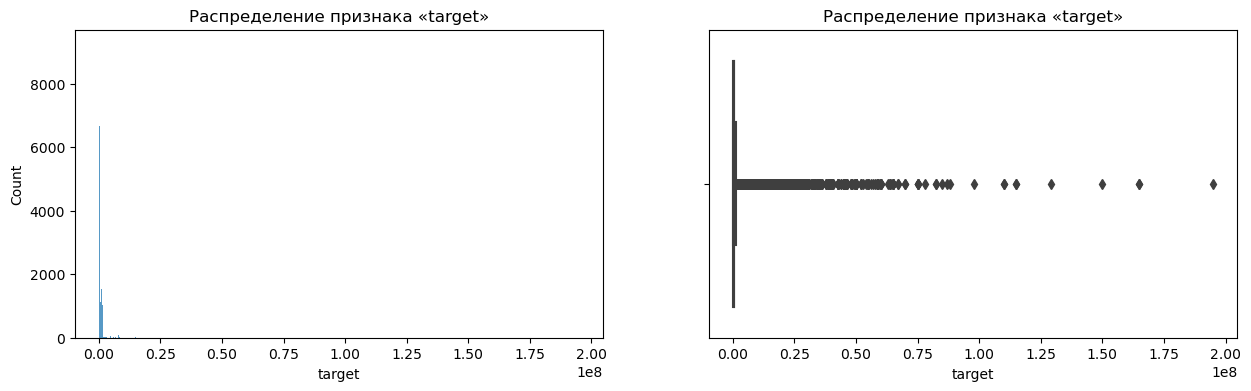

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='target', ax=axes[0]);
histplot.set_title('Распределение признака «target»');
# histplot.axvline(df_v14['target'].mean(), color='red', lw=2)

boxplot = sns.boxplot(data=df, x='target', ax=axes[1]);
boxplot.set_title('Распределение признака «target»');

Распределение по выбранным штатам

/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


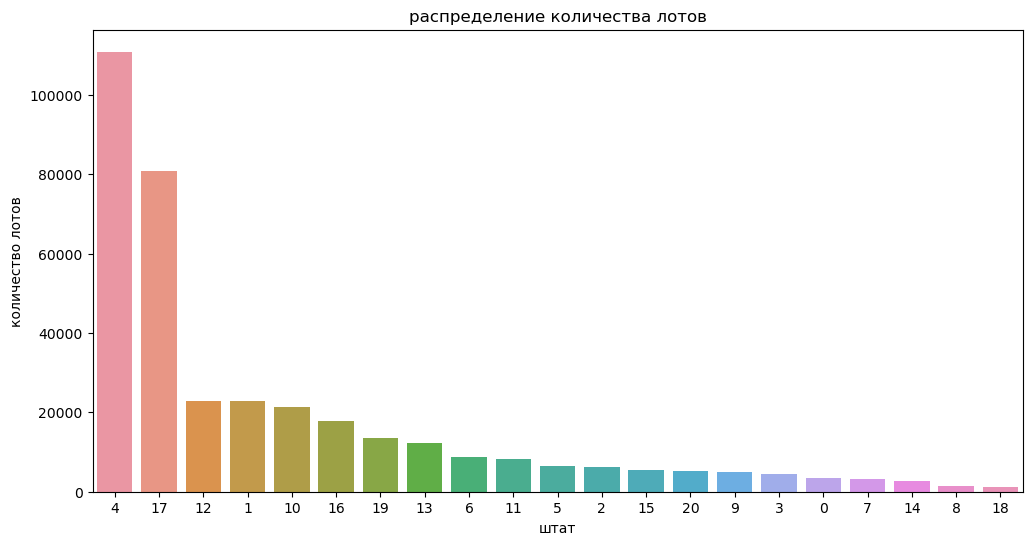

In [ ]:
order=df.value_counts('state')
plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
bar = sns.barplot(data=df, x="state", y='target', estimator=len, order=order.index)
bar.set_title("распределение количества лотов")
bar.set_xlabel("штат")
bar.set_ylabel("количество лотов")
plt.show()

Распределение target в логарифмическом масштабе

/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


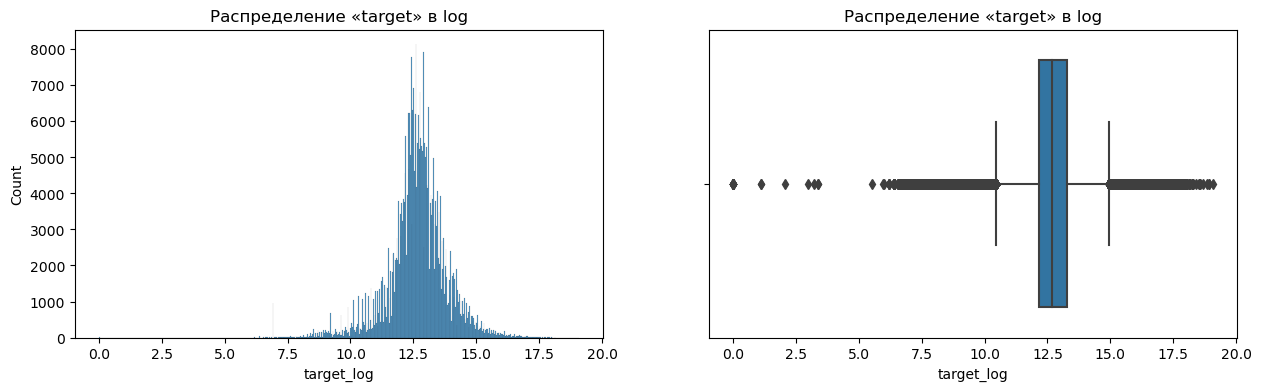

In [ ]:
df['target_log'] = np.log(df['target'])

# посмотрю на графики
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='target_log', ax=axes[0]);
histplot.set_title('Распределение «target» в log');
boxplot = sns.boxplot(data=df, x='target_log', ax=axes[1]);
boxplot.set_title('Распределение «target» в log');

In [ ]:
df['target_log']

0         12.943237
1         12.644328
2         14.878496
3         14.688894
4          8.517193
            ...    
364455    14.037854
364456    13.422466
364457    13.176852
364458    10.448715
364459    12.230277
Name: target_log, Length: 364460, dtype: float64

Проверка на нормальность распределения данных

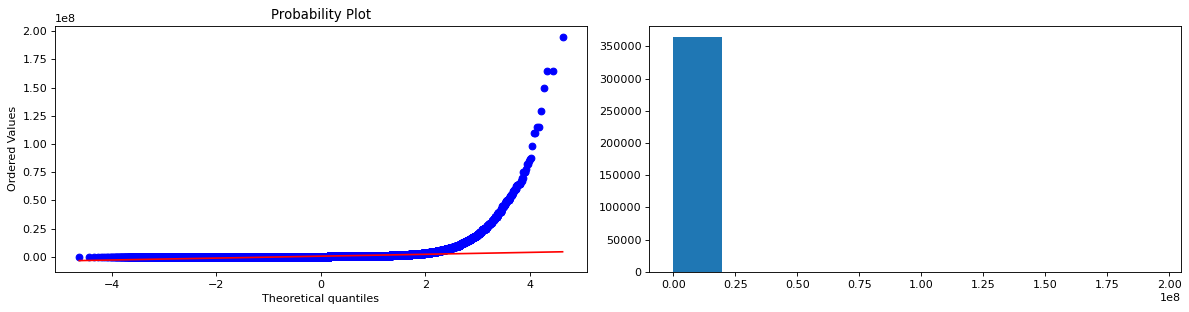

In [ ]:
plt.figure(figsize=(15, 4), dpi=80)
plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(df['target'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(df['target']) # гистограмма распределения признака

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout
plt.show()

видим, что этот набор данных не соответствует нормальному распределению в районе правого хвоста.
То есть по графическим тестам мы можем сказать, что данные не имеют нормальной тенденции.

In [ ]:
_, p = stats.normaltest(df.target_log)
#normaltest возвращает двустороннюю вероятность для проверки гипотезы поэтому уровень значимости делим на 2
print('p=%.2f' % p)

if p > 0.05/2:
    print('Тест на нормальность данных пройден успешно!')
else:
    print('Тест на нормальность данных НЕ пройден!')

p=0.00
Тест на нормальность данных НЕ пройден!


In [ ]:
missing_data_in_df=pd.DataFrame({'NaN_Counts': df.isna().sum(), 'NaN_Proportions(%)': (df.isna().sum() / df.shape[0]) * 100}).sort_values(by='NaN_Counts', ascending=False)
missing_data_in_df

,NaN_Counts,NaN_Proportions(%)
stories,156246,42.870548
beds,123408,33.860506
lotsize,117716,32.298743
baths,116677,32.013664
Year built,57281,15.716677
sqft,47715,13.091972
status,0,0.000000
propertyType,0,0.000000
city,0,0.000000
state,0,0.000000


Заполнение пустых данных через моду/медиану/среднее

In [ ]:
df['stories'].mode()

0    1.0
Name: stories, dtype: float64

In [ ]:
df['beds'].mode()

0    3.0
Name: beds, dtype: float64

In [ ]:
df['baths'].mode()

0    2.0
Name: baths, dtype: float64

In [ ]:
df['Year built'].mode()

0    2019.0
Name: Year built, dtype: float64

In [ ]:
df.loc[df['stories'].isnull(), 'stories'] = 2
df.loc[df['lotsize'].isnull(), 'lotsize'] = df['lotsize'].median()
df.loc[df['beds'].isnull(), 'beds'] = 3
df.loc[df['baths'].isnull(), 'baths'] = 2
df.loc[df['Year built'].isnull(), 'Year built'] = 2019
df.loc[df['sqft'].isnull(), 'sqft'] = df['sqft'].median()

In [ ]:
df_drop=df.drop(['stories', 'lotsize', 'beds', 'baths', 'PrivatePool'], axis=1)

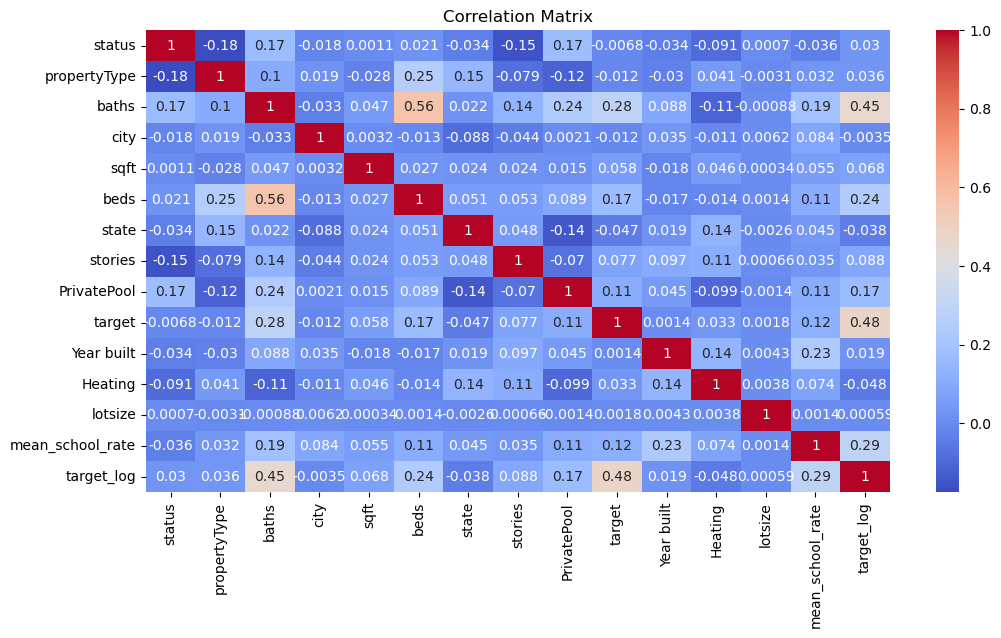

In [ ]:
# Построение матрицы корреляции
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
correlation_matrix = df.corr()

# Нахождение пар данных с коэффициентом корреляции по модулю больше 0.2
high_corr_pairs = correlation_matrix[(correlation_matrix.abs() > 0.2)]

# Вывод пар данных с высокой корреляцией
print(high_corr_pairs)

                  status  propertyType     baths  city  sqft      beds  state  \
status               1.0           NaN       NaN   NaN   NaN       NaN    NaN   
propertyType         NaN      1.000000       NaN   NaN   NaN  0.253138    NaN   
baths                NaN           NaN  1.000000   NaN   NaN  0.559749    NaN   
city                 NaN           NaN       NaN   1.0   NaN       NaN    NaN   
sqft                 NaN           NaN       NaN   NaN   1.0       NaN    NaN   
beds                 NaN      0.253138  0.559749   NaN   NaN  1.000000    NaN   
state                NaN           NaN       NaN   NaN   NaN       NaN    1.0   
stories              NaN           NaN       NaN   NaN   NaN       NaN    NaN   
PrivatePool          NaN           NaN  0.238096   NaN   NaN       NaN    NaN   
target               NaN           NaN  0.284089   NaN   NaN       NaN    NaN   
Year built           NaN           NaN       NaN   NaN   NaN       NaN    NaN   
Heating              NaN    

In [ ]:
df=df.drop('baths', axis=1) #следует из высокой корреляции с данными

Перейдём непосредственно к обучению модели

In [ ]:
X=df.drop(['target', 'target_log'], axis=1)
y=df['target']
y_log = df['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
from sklearn.feature_selection import f_regression

select = feature_selection.SelectKBest(score_func = f_regression, k=12)
z = select.fit_transform(X_train,y_train_log)

In [ ]:
filter_kb = select.get_support()

features = X_train.columns
print(features[filter_kb])

Index(['status', 'propertyType', 'city', 'sqft', 'beds', 'state', 'stories',
       'PrivatePool', 'Year built', 'Heating', 'lotsize', 'mean_school_rate'],
      dtype='object')


In [ ]:
X.columns

Index(['status', 'propertyType', 'city', 'sqft', 'beds', 'state', 'stories',
       'PrivatePool', 'Year built', 'Heating', 'lotsize', 'mean_school_rate'],
      dtype='object')

Масштабирование данных

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h4>Подбор модели для регрессии</h4>

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>R</mi>
  <mi>M</mi>
  <mi>S</mi>
  <mi>L</mi>
  <mi>E</mi>
  <mo>=</mo>
  <msqrt>
    <mfrac>
      <mn>1</mn>
      <mi>n</mi>
    </mfrac>
    <munderover>
      <mo data-mjx-texclass="OP">&#x2211;</mo>
      <mrow data-mjx-texclass="ORD">
        <mi>i</mi>
        <mo>=</mo>
        <mn>1</mn>
      </mrow>
      <mrow data-mjx-texclass="ORD">
        <mi>n</mi>
      </mrow>
    </munderover>
    <mo stretchy="false">(</mo>
    <mi>l</mi>
    <mi>o</mi>
    <mi>g</mi>
    <mo stretchy="false">(</mo>
    <msub>
      <mi>y</mi>
      <mi>i</mi>
    </msub>
    <mo stretchy="false">)</mo>
    <mo>&#x2212;</mo>
    <mi>l</mi>
    <mi>o</mi>
    <mi>g</mi>
    <mo stretchy="false">(</mo>
    <msub>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mi>y</mi>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mi>i</mi>
    </msub>
    <mo stretchy="false">)</mo>
    <msup>
      <mo stretchy="false">)</mo>
      <mn>2</mn>
    </msup>
  </msqrt>
</math>>
      <mn>2</mn>
    </msup>
  </msqrt>
</math>

Линейная регрессия

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(X_train_scaled, y_train_log)
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

In [ ]:
# исходя из формулы RMSLE нужно взять корень от MSE
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_pred))))

Train RMSLE score: 1.08
Test RMSLE score: 1.08


Полиномиальная регрессия

In [ ]:
poly = preprocessing.PolynomialFeatures(include_bias=False) # degree=2 по-умолчанию
poly.fit(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для валидационной выборки
X_test_poly = poly.transform(X_test_scaled)

In [ ]:
#Создаём объект класса LinearRegression
reg_poly = linear_model.LinearRegression()
#Обучаем модель
reg_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = reg_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
y_test_predict_poly = reg_poly.predict(X_test_poly)

In [ ]:
# метрики для полиноминальной регрессии
print('Polynomial Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Polynomial Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly))))

Polynomial Train RMSLE score: 1.00
Polynomial Test RMSLE score: 0.99


Дерево решений

In [ ]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train_log)

y_train_predict_dtr = dtr.predict(X_train_scaled)
y_test_predict_dtr = dtr.predict(X_test_scaled)

In [ ]:
# метрики для DecisionTreeRegressor
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_dtr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_dtr))))

DecisionTreeRegressor Train RMSLE score: 0.19
DecisionTreeRegressor Test RMSLE score: 0.72


Наблюдаем явное переобучение, проведём подбор параметров модели

In [ ]:
# Задам словарь гиперпараметров для GridSearchCV
param_grid_DTR = {
              'max_depth': list(np.arange(6,21)) # максимальная глубина дерева
              }

In [ ]:
#Создаем объект класса
grid_search_DTR = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(),
    param_grid=param_grid_DTR,
    n_jobs = -1,
    scoring='neg_mean_squared_error')

In [ ]:
# Запускаем подбор гиперпараметров
grid_search_DTR.fit(X_train_scaled, y_train_log)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_DTR.best_params_

{'max_depth': 16}

In [ ]:
# раз мы явно указали метрику -MSLE, то теперь можно посмотреть ее через данный метод
_MSLE = grid_search_DTR.score(X_test_scaled, y_test_log)
_MSLE

-0.43659096144256077

In [ ]:
# ну и наша метрика
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(-_MSLE)))

DecisionTreeRegressor Test RMSLE score: 0.66


Посмотрим на графики, как менялись метрики в зависимости от глубины дерева

In [ ]:
RMSLE_tr=[]
RMSLE_test=[]
for n in np.arange(6,21):
    dtr2 = tree.DecisionTreeRegressor(max_depth=n)
    dtr2.fit(X_train_scaled, y_train_log)
    y_train_predict_dtr2 = dtr2.predict(X_train_scaled)
    y_test_predict_dtr2 = dtr2.predict(X_test_scaled)
    mse_gs_train = metrics.mean_squared_error(y_train_predict_dtr2, y_train_log)
    mse_gs_test = metrics.mean_squared_error(y_test_predict_dtr2, y_test_log)
    RMSLE_tr.append(round(mse_gs_train**0.5, 2))
    RMSLE_test.append(mse_gs_test**0.5)

In [ ]:
# создадим фрейм
rmsle = pd.DataFrame({"depth":np.arange(6,21),"train":RMSLE_tr,"test":RMSLE_test})

/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kali/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

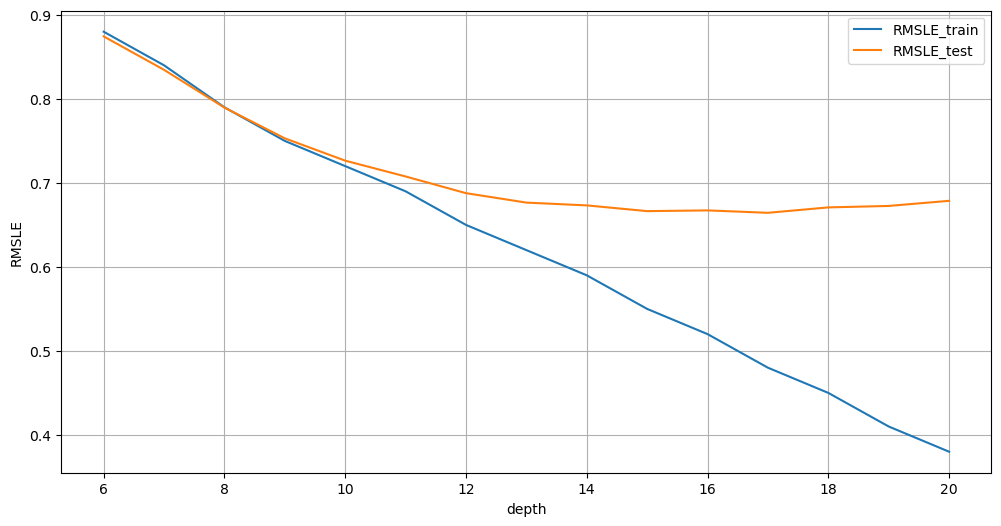

In [ ]:
fig, axs = plt.subplots()
line = sns.lineplot(data=rmsle,x="depth",y="train",label="RMSLE_train")
line2 = sns.lineplot(data=rmsle,x="depth",y="test",label="RMSLE_test")
line.set_ylabel("RMSLE")
axs.grid()

<h4>Ансамбли</h4>

RandomForestRegressor

In [ ]:
rfr = ensemble.RandomForestRegressor(max_depth=16,
                                  n_estimators=200,
                                  min_samples_split = 20,
                                  random_state=42,
                                    n_jobs = -1)

rfr.fit(X_train_scaled, y_train_log)

y_train_predict_rfr = rfr.predict(X_train_scaled)
y_test_predict_rfr = rfr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_rfr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_rfr))))

Train RMSLE score: 0.52
Test RMSLE score: 0.59


In [ ]:
y_test = np.exp(y_test_log)
y_test_predict = np.exp(y_test_predict_rfr)

mae_test = metrics.mean_absolute_error(y_test, y_test_predict)
mae_test

246874.18323546925

GradientBoostingRegressor

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.1,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.61
Test RMSLE score: 0.61


<AxesSubplot: >

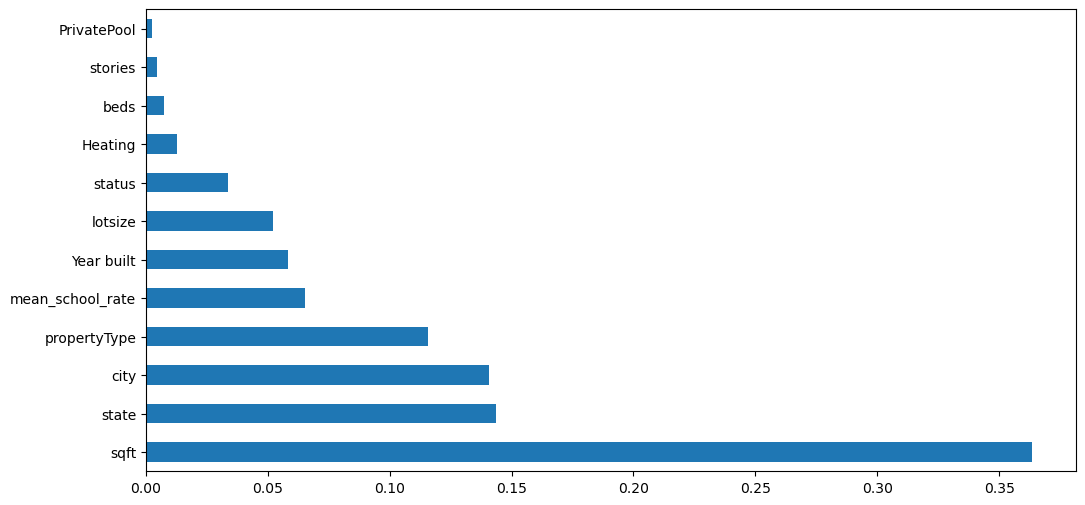

In [ ]:
# есть возможность вывести самые важные признаки для модели через атрибут feature_importances_
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

In [ ]:
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

mae_test = metrics.median_absolute_error(y_test, y65_test_predict)
mae_test

72923.84093282731

In [ ]:
msa = mean_absolute_error(y_test, y65_test_predict)
msa

264279.6939673142

Рассмотрим результаты прогноза df_drop. Сразу с ансамблевых методов

In [ ]:
X=df_drop.drop(['target', 'target_log'], axis=1)
y=df_drop['target']
y_log = df_drop['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.57
Test RMSLE score: 0.60


In [ ]:
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

msa = metrics.mean_absolute_error(y_test, y65_test_predict)
msa

251034.97136444304

Учтём что в city было выбрано большое количество данных, закодированных под labelencoder, рассмотрим результаты без них

In [ ]:
df_drop_c=df_drop.drop('city', axis=1)

In [ ]:
X=df_drop_c.drop(['target', 'target_log'], axis=1)
y=df_drop_c['target']
y_log = df_drop_c['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.1,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.69
Test RMSLE score: 0.70


In [ ]:
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

msa = metrics.mean_absolute_error(y_test, y65_test_predict)
msa

289204.15033761016

Всё это время мы проверяли результат на основе кодировки LabelEncoder, попробуем на основании имеющейся кодировки перекодировать данные дальше

In [ ]:
df_cod=df_drop

In [ ]:
df_cod.columns

Index(['status', 'propertyType', 'city', 'sqft', 'state', 'target',
       'Year built', 'Heating', 'mean_school_rate', 'target_log'],
      dtype='object')

'status' - 10 значений, 'propertyType'-20 значений, 'city' -256 значений, 'state' -20 значений, 'Heating' - 10 значений- рассмотрим следующие столбцы

'propertyType', 'city', 'state' столбцы BinaryEncoder

In [ ]:
import category_encoders as ce
# Создание экземпляра бинарного кодировщика
encoder = ce.BinaryEncoder(cols=['propertyType', 'city', 'state'])

# Применение бинарного кодировщика к датафрейму df
df_cod = encoder.fit_transform(df_cod)

'status', 'Heating' закодируем с помощью get_dummies

In [ ]:
df_cod = pd.get_dummies(df_cod, columns=['status'])
df_cod = pd.get_dummies(df_cod, columns=['Heating'])

In [ ]:
len(df_cod.columns)

46

Обучим данную модель с помощью градиентного бустинга

In [ ]:
X=df_cod.drop(['target', 'target_log'], axis=1)
y=df_cod['target']
y_log = df_cod['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.60
Test RMSLE score: 0.62


In [ ]:
y_test1 = np.exp(y_test_log)
y65_test_predict1 = np.exp(y_test_predict_gbr)

msa = metrics.mean_absolute_error(y_test, y65_test_predict1)
msa

261665.65407248813

Рассмотрим результаты при отсутствии 'city'

In [ ]:
df_drop.columns

Index(['status', 'propertyType', 'city', 'sqft', 'state', 'target',
       'Year built', 'Heating', 'mean_school_rate', 'target_log'],
      dtype='object')

In [ ]:
df_drop1=df_drop.drop('city', axis=1)

In [ ]:
df_drop1 = pd.get_dummies(df_drop1, columns=['status', 'Heating'])

In [ ]:
encoder = ce.BinaryEncoder(cols=['propertyType', 'state'])

# Применение бинарного кодировщика к датафрейму df
df_drop1 = encoder.fit_transform(df_drop1)

In [ ]:
len(df_drop1.columns)

37

In [ ]:
X=df_drop1.drop(['target', 'target_log'], axis=1)
y=df_drop1['target']
y_log = df_drop1['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.65
Test RMSLE score: 0.67


In [ ]:
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

msa = metrics.mean_absolute_error(y_test, y65_test_predict)
msa

284806.49460770143

И напоследок попробуем закодировать ProrertyType под get_dummies

In [ ]:
df_cod1=df_drop

In [ ]:
import category_encoders as ce
# Создание экземпляра бинарного кодировщика
encoder = ce.BinaryEncoder(cols=['city', 'state'])

# Применение бинарного кодировщика к датафрейму df
df_cod1 = encoder.fit_transform(df_cod1)

df_cod1 = pd.get_dummies(df_cod1, columns=['status'])
df_cod1 = pd.get_dummies(df_cod1, columns=['Heating'])
df_cod1 = pd.get_dummies(df_cod1, columns=['propertyType'])

len(df_cod1.columns)

57

In [ ]:
df_cod1.columns

Index(['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6',
       'city_7', 'city_8', 'sqft', 'state_0', 'state_1', 'state_2', 'state_3',
       'state_4', 'target', 'Year built', 'mean_school_rate', 'target_log',
       'status_0', 'status_1', 'status_2', 'status_3', 'status_4', 'status_5',
       'status_6', 'status_7', 'status_8', 'status_9', 'status_10',
       'Heating_0', 'Heating_1', 'Heating_2', 'Heating_3', 'Heating_4',
       'Heating_5', 'Heating_6', 'Heating_7', 'Heating_8', 'Heating_9',
       'Heating_10', 'propertyType_0', 'propertyType_1', 'propertyType_2',
       'propertyType_3', 'propertyType_4', 'propertyType_5', 'propertyType_6',
       'propertyType_7', 'propertyType_8', 'propertyType_9', 'propertyType_10',
       'propertyType_11', 'propertyType_12', 'propertyType_13',
       'propertyType_14', 'propertyType_15'],
      dtype='object')

In [ ]:
X=df_cod1.drop(['target', 'target_log'], axis=1)
y=df_cod1['target']
y_log = df_cod1['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.58
Test RMSLE score: 0.61


In [ ]:
y_test2 = np.exp(y_test_log)
y65_test_predict2 = np.exp(y_test_predict_gbr)

msa = metrics.mean_absolute_error(y_test2, y65_test_predict2)
msa

257807.29142068556

Показатели улучшились :) Попробуем то же самое, добавив 'state' и на всех фичах(показатели оказались лучше)

In [ ]:
df_cod2=df

In [ ]:
import category_encoders as ce
# Создание экземпляра бинарного кодировщика
encoder = ce.BinaryEncoder(cols=['city'])

# Применение бинарного кодировщика к датафрейму df
df_cod2 = encoder.fit_transform(df_cod2)

df_cod2 = pd.get_dummies(df_cod2, columns=['status'])
df_cod2 = pd.get_dummies(df_cod2, columns=['Heating'])
df_cod2 = pd.get_dummies(df_cod2, columns=['propertyType'])
df_cod2 = pd.get_dummies(df_cod2, columns=['state'])

len(df_cod2.columns)

77

In [ ]:
df_cod2.columns

Index(['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6',
       'city_7', 'city_8', 'sqft', 'beds', 'stories', 'PrivatePool', 'target',
       'Year built', 'lotsize', 'mean_school_rate', 'target_log', 'status_0',
       'status_1', 'status_2', 'status_3', 'status_4', 'status_5', 'status_6',
       'status_7', 'status_8', 'status_9', 'status_10', 'Heating_0',
       'Heating_1', 'Heating_2', 'Heating_3', 'Heating_4', 'Heating_5',
       'Heating_6', 'Heating_7', 'Heating_8', 'Heating_9', 'Heating_10',
       'propertyType_0', 'propertyType_1', 'propertyType_2', 'propertyType_3',
       'propertyType_4', 'propertyType_5', 'propertyType_6', 'propertyType_7',
       'propertyType_8', 'propertyType_9', 'propertyType_10',
       'propertyType_11', 'propertyType_12', 'propertyType_13',
       'propertyType_14', 'propertyType_15', 'state_0', 'state_1', 'state_2',
       'state_3', 'state_4', 'state_5', 'state_6', 'state_7', 'state_8',
       'state_9', 'state_10', 'state_1

In [ ]:
X=df_cod2.drop(['target', 'target_log'], axis=1)
y=df_cod2['target']
y_log = df_cod2['target_log']

In [ ]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

Train RMSLE score: 0.54
Test RMSLE score: 0.57


In [ ]:
y_test3 = np.exp(y_test_log)
y65_test_predict3 = np.exp(y_test_predict_gbr)

msa = metrics.mean_absolute_error(y_test3, y65_test_predict3)
msa

249927.4924670404

df_cod2 выдаёт лучшие результаты по msa

In [ ]:
df_cod2.columns

Index(['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6',
       'city_7', 'city_8', 'sqft', 'beds', 'stories', 'PrivatePool', 'target',
       'Year built', 'lotsize', 'mean_school_rate', 'target_log', 'status_0',
       'status_1', 'status_2', 'status_3', 'status_4', 'status_5', 'status_6',
       'status_7', 'status_8', 'status_9', 'status_10', 'Heating_0',
       'Heating_1', 'Heating_2', 'Heating_3', 'Heating_4', 'Heating_5',
       'Heating_6', 'Heating_7', 'Heating_8', 'Heating_9', 'Heating_10',
       'propertyType_0', 'propertyType_1', 'propertyType_2', 'propertyType_3',
       'propertyType_4', 'propertyType_5', 'propertyType_6', 'propertyType_7',
       'propertyType_8', 'propertyType_9', 'propertyType_10',
       'propertyType_11', 'propertyType_12', 'propertyType_13',
       'propertyType_14', 'propertyType_15', 'state_0', 'state_1', 'state_2',
       'state_3', 'state_4', 'state_5', 'state_6', 'state_7', 'state_8',
       'state_9', 'state_10', 'state_1

In [ ]:
df_drop.columns # с данными колонками работаем на тесте

Index(['status', 'propertyType', 'city', 'sqft', 'state', 'target',
       'Year built', 'Heating', 'mean_school_rate', 'target_log'],
      dtype='object')

Посмотрим в сравнении показатели таргета и предсказаний

In [ ]:
columns = ['target', 'target_pred']
df_tar = pd.DataFrame(columns=columns)
df_tar['target']=y_test3
df_tar['target_pred']=y65_test_predict3

In [ ]:
df_tar['target_pred'] = df_tar['target_pred'].astype(int)

In [ ]:
df_tar['target']=df_tar['target'].astype(int)

In [ ]:
df_tar.head()

,target,target_pred
156272,154990,190967
123170,126899,218285
172480,318489,357296
242459,730000,634357
23281,619950,433627


Оценим число предсказаний которые отличаются от таргета <100000

In [ ]:
df_tar['abs_diff'] = abs(df_tar['target'] - df_tar['target_pred'])
# Подсчитываем процент значений, удовлетворяющих условию
percent_below = (df_tar[df_tar['abs_diff'] <100000].shape[0] / df_tar.shape[0]) * 100
percent_below

61.96930618815051

In [ ]:
sorted_df = df_tar.sort_index() #сортировка по индексам

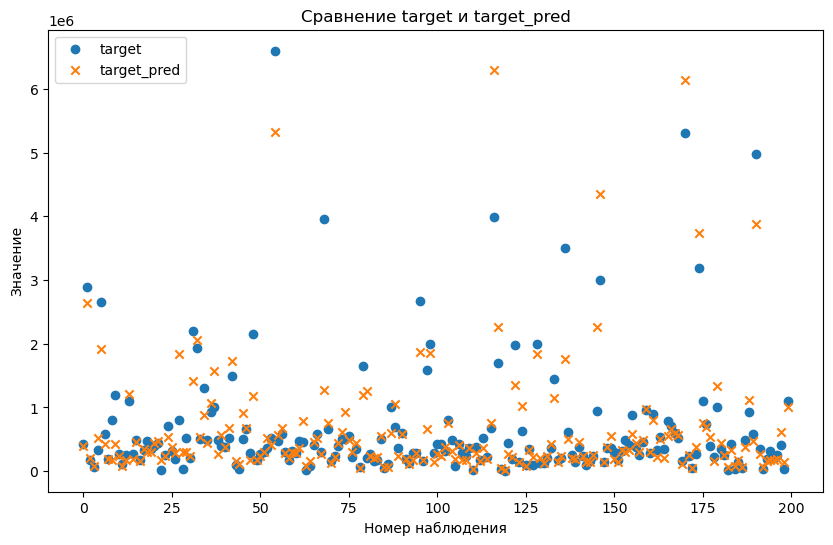

In [ ]:
# Построение графика разницы target и target_pred для первых 200 точек
plt.figure(figsize=(10, 6))
plt.scatter(range(200), sorted_df['target'][:200], label='target', marker='o')
plt.scatter(range(200), sorted_df['target_pred'][:200], label='target_pred', marker='x')
plt.xlabel('Номер наблюдения')
plt.ylabel('Значение')
plt.title('Сравнение target и target_pred')
plt.legend()
plt.show()

In [ ]:
len(df[df['target']<500000]) #большая часть выборки построена на таргете <500000, присутствуют выбросы

256474

Соответственно на тесте работаем с теми же фичами, с аналогичным форматом кодировок, что и в последнем варианте.

Обучим модель на всех данных

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)

In [ ]:
gbr_result = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr_result.fit(X_train_scaled, y_log)

y_train_predict_gbr = gbr_result.predict(X_train_scaled)

# метрики
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y, y_train_predict_gbr))))

Train RMSLE score: 1949288.75


In [ ]:
y_test = np.exp(y_log)
y65_test_predict = np.exp(y_train_predict_gbr)

msa = metrics.mean_absolute_error(y_test, y65_test_predict)
msa

238405.3576538492